We start with 80 MSA's and matching PDB files that were curated for the following paper. 

4.	Zerihun, Mehari B, et al. “CoCoNet: Boosting RNA Contact Prediction by Convolutional Neural Networks.” 2020, https://doi.org/10.1101/2020.07.30.229484.![image.png](attachment:image.png)

Here is the github where they can be downloaded. https://github.com/KIT-MBS/coconet

At the time (two years ago) this was all the RNA structures that had been imaged with less than 4 angstrom resolution. There are a few more now, which we will be adding, but it is a small dataset. 



The first step is to run the PDB files through the RNAView command line tool which produces annotations that label each bond in the structure as shown below in a short example. In this example base 1 and base 119 are bonded by a -/- cis bond (this is a U-A watson crick bond)


    




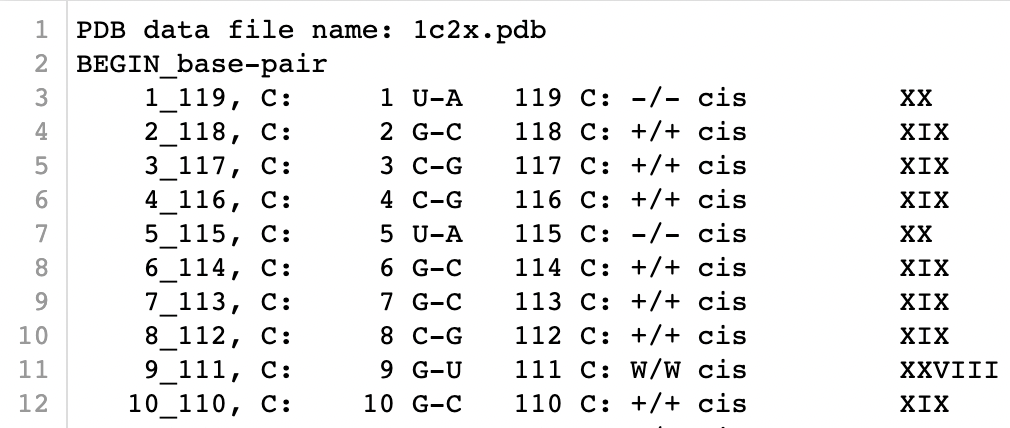

The bondtypes are classified by the leontis westhof notation from this paper 
1.	Leontis,N.B. and Westhof,E. ( 2001 ) Geometric nomenclature and classification of RNA base pairs. RNA , 7 , 499 –512 

Basically there are three edges to the base that can bond to any three edges on the other base.

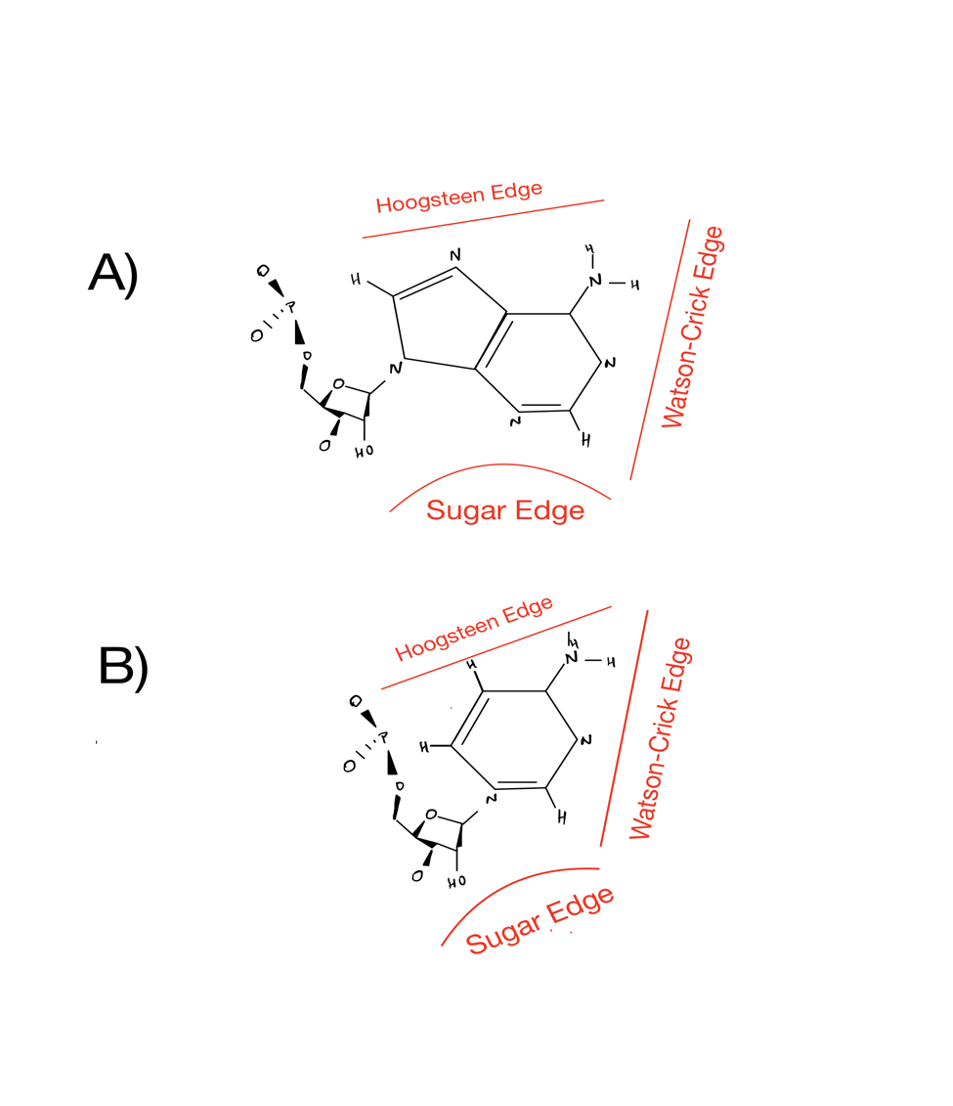

This leads to the following 12 ways to classify RNA bonds
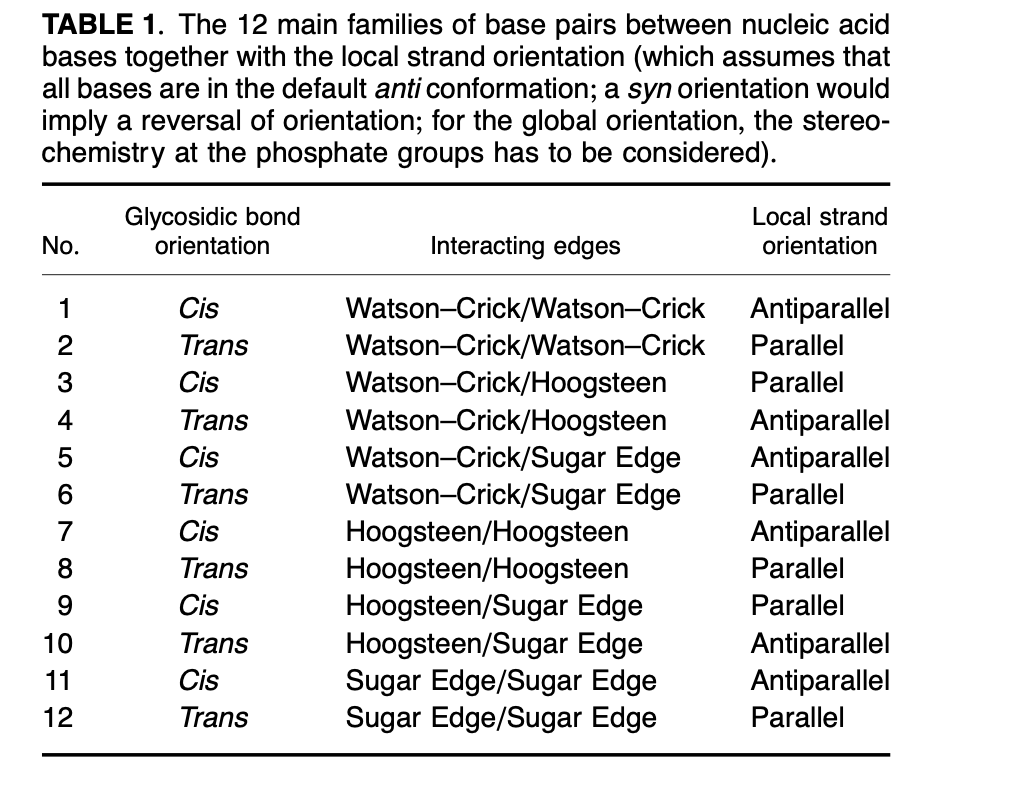

We would like to be able to recognize a bond and then classify it into one of these types. So far i am just applying my work to recognizing bonds. 

So i parse the RNAView output as follows 

In [2]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import os 
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
def parse_rnaview(path):
    '''
    takes path to folder containing rnaview output files (in format .out) 
    returns pandas dataframe with columns set as filename, bases in bond, bondtype (lewontis-westhoff)
    and base 1 numbering and base 2 numbering
    '''
    li = []
    path = path                     
    all_files = glob.glob(path + "/*.out")
   
    for filename in all_files:
        
        
        df = pd.read_csv(filename, sep="\t") #this reads in the file as a pandas dataframe but it is messy
        file = list(df)[0][1:]
        df = df.rename(columns = {list(df)[0]:'Col_1'})
        
        begin = df.index[df['Col_1'] == 'BEGIN_base-pair'][0] #this slices out the header of the file
        end = df.index[df['Col_1'] == 'END_base-pair'][0] #this removes the footer, leaving just base pairing info
        
        df = df[1:end]
        df = df[begin:]
        df.index.astype(np.int64)
        
        df['file'] = str(file)[19:] #will need to change this if your filepath is different
        df[['a','b','c']] = df['Col_1'].str.split(':', expand=True) # all the rest is formatting to get the dataframe 
        df[['base_1','base_2']] = df['a'].str.split('_', expand = True)#how i want it 
        df['base_2'] = df['base_2'].astype(str).str[:-3].astype(np.int64)
        df['base_1'] = df['base_1'].astype(np.int64)
        df.drop(['a','Col_1'], axis = 1)
        df.rename(columns = {'c':'bond_type'}, inplace = True)
        df.drop(['a','Col_1'], axis = 1, inplace = True)
        df['b'] = df['b'].astype(str).str[7:-7]
        df.rename(columns = {'b':'bond_bases'}, inplace = True)
        df['positions'] = df['base_1'].astype(str) +':'+ df['base_2'].astype(str)
        li.append(df)
        
        
       
       
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [18]:
df = parse_rnaview('basepairtypes/') #run the previous function


In [19]:
#this is how the dataframe looks now
df

,file,bond_bases,bond_type,base_1,base_2,positions
0,4k27_U.pdb,G-C,+/+ cis XIX,1,55,1:55
1,4k27_U.pdb,C-G,+/+ cis XIX,2,54,2:54
2,4k27_U.pdb,C-G,+/+ cis XIX,3,53,3:53
3,4k27_U.pdb,C-G,+/+ cis XIX,4,52,4:52
4,4k27_U.pdb,G-C,+/+ cis XIX,7,49,7:49
...,...,...,...,...,...,...
5200,5ddp.pdb,C-G,+/+ cis XIX,34,45,34:45
5201,5ddp.pdb,G-A,W/H cis syn IX,54,56,54:56
5202,5ddp.pdb,G-A,W/H tran syn !1H(b_b),22,57,22:57
5203,5ddp.pdb,G-C,W/W tran syn !1H(b_b),22,58,22:58


In [ ]:
df.to_csv('RNAViewDf80.csv') #write the dataframe to a .csv file 

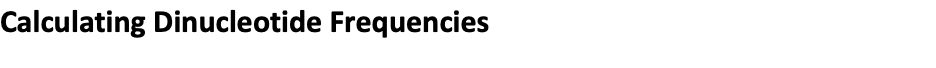
Next i want to calculate dinucleotide frequencies for every pair of positions i,j along a given MSA. Then i will label that position as either not a bond or a bond (and its type) using the previously parsed RNAView output. 

In [27]:
#this matches RFAM MSA's to pdb files 
fileDict = {'RF00001': '1C2X',
 'RF00008': '5DI2',
 'RF00017': '1L9A',
 'RF00023': '1P6V',
 'RF00027': '5ZAL',
 'RF00102': '6OL3',
 'RF00166': '2MF0',
 'RF00174': '4GMA',
 'RF00207': '2KE6',
 'RF00209': '4C4Q',
 'RF00210': '2NBX',
 'RF00374': '1S9S',
 'RF00480': '1Z2J',
 'RF00500': '2KRL',
 'RF00634': '6UES',
 'RF01073': '2LC8',
 'RF01381': '2N1Q',
 'RF01704': '6QN3',
 'RF01727': '6HAG',
 'RF01739': '5DDP',
 'RF01857': '3NDB',
 'RF01998': '3BWP',
 'RF02012': '4R0D',
 'RF00005_1': '1EHZ',
 'RF01852': '3RG5',
 'RF00059': '3D2G',
 'RF00100': '5LYS',
 'RF00162': '3GX5',
 'RF00167': '4TZX',
 'RF00168': '3DIL',
 'RF00234': '2H0S',
 'RF00380': '3PDR',
 'RF01051': '4YAZ',
 'RF01510': '3SLQ',
 'RF01734': '4ENC',
 'RF01750': '4XWF',
 'RF01763': '5NWQ',
 'RF01786': '3Q3Z',
 'RF01831_1': '4LVV',
 'RF01854': '4WFL',
 'RF00028_1': '1GID',
 'RF00169': '1Z43',
 'RF01767': '3E5C',
 'RF02682': '3NKB',
 'RF00163': '3ZP8',
 'RF01054': '4JF2',
 'RF02695': '4K27',
 'RF00233': '4P5J',
 'RF01807': '4P95',
 'RF01415': '4PQV',
 'RF00379': '4QLN',
 'RF02683': '4RUM',
 'RF00921': '5DUN',
 'RF02679': '5K7D',
 'RF01982': '5KPY',
 'RF00606_1': '5M0H',
 'RF01300': '5OB3',
 'RF02681': '5T5A',
 'RF00442_1': '5U3G',
 'RF00080': '6CB3',
 'RF01826': '6FZ0',
 'RF03017': '2OIU',
 'RF00011_1': '1NBS',
 'RF02540': '1FFZ',
 'RF00029': '1KXK',
 'RF00010': '1U9S',
 'RF00164': '1XJR',
 'RF00458': '2IL9',
 'RF00050': '3F2Q',
 'RF00504': '3OX0',
 'RF00044': '3R4F',
 'RF00061_2': '3T4B',
 'RF01689': '4FRG',
 'RF02447': '4JRC',
 'RF01725': '4L81',
 'RF02266': '4PLX',
 'RF02927': '4R4V',
 'RF02680': '4RZD',
 'RF02001_2': '4Y1O',
 'RF02553': '6CU1'}

In [28]:
def make_vector(l1,l2):
    '''
    takes two lists -in this case the list of nucleotides at position i and another at position j of msa-
    returns a list/vector of the fraction of total pairs of each possible dinucleotide pair. 
    '''
    pair_dict = Counter({
        ('G', 'A'): 1,
        ('G', 'G'): 1,
        ('G', 'C'): 1,
        ('G', 'U'): 1,
        ('G', '-'): 1,
        
        ('C', 'C'): 1,
        ('C', 'U'): 1,
        ('C', 'G'): 1,
        ('C', 'A'): 1,
        ('C', '-'): 1,
        
        ('U', 'A'): 1,
        ('U', 'G'): 1,
        ('U', '-'): 1,
        ('U', 'U'): 1,
        ('U', 'C'): 1,
        
        ('A', '-'): 1,
        ('A', 'G'): 1,
        ('A', 'U'): 1,
        ('A', 'C'): 1,
        ('A', 'A'): 1,
         
        ('-', '-'): 1,
        ('-', 'C'): 1,
        ('-', 'U'): 1,
        ('-', 'G'): 1,
        ('-', 'A'): 1})
                   
    d = Counter(list(zip(l1,l2)))
    a = d + pair_dict

    for key, value in a.items():
        pair_dict[key] = round(((value-1)/(sum(a.values())-25)),4)
    return list(pair_dict.values())

In [29]:
def read_file(filename):
    
    with open (filename, 'r') as rf:
        return [l.strip() for l in rf.readlines()]

def split(sequence):
    return [char for char in sequence]


def makeSeqList(filename):
    '''
    takes a msa in fasta format and makes a list of sequences like ['seq1','seq2', etc]
    '''
    FASTAFile = read_file(filename)
    FASTADict = {}
    FASTALabel = ''
    for line in FASTAFile:
        if '>' in line:
            FASTALabel = line
            FASTADict[FASTALabel]= ''
        else:
            FASTADict[FASTALabel]+= line.replace('M','-').replace('Y','-').replace('N','-').replace('R','-').replace('W','-').replace('H','-').replace('K','-').replace('S','-').replace('n','-').replace('B','-').replace('D','-').replace('V','-')
    SeqListStr = []
    for i in FASTADict:
        SeqListStr.append(FASTADict[i])
    SeqList = []
    for sequence in SeqListStr:
        SeqList.append(split(sequence))

    return SeqList


def make_array(SeqList):
    '''
    takes a list of sequences and makes them into an array that represents a msa like [
                                                                                        [a,u,c,g],
                                                                                        [a,u,g,c],
                                                                                        [a,g,c,u],
                                                                                        ]
    '''
    
    rows = len(SeqList)
    ResiduesPerSequence = len(SeqList[0])
    SequenceMatrix = np.zeros([rows,ResiduesPerSequence],dtype=list)
    cc = int(ResiduesPerSequence*(ResiduesPerSequence))
    ResiduePairMatrix = np.zeros([cc,rows], dtype=list)
    MatrixCount=0
    for i in SeqList:
        SequenceMatrix[MatrixCount] = i
        MatrixCount+=1
    return SequenceMatrix

In [ ]:
def make_dinucleotide_freq_array(array):
    
    '''
    makes an lxlx25 array where each position i,j in the lxl array represents position i compared to position j in 
    the rna sequence. Then at each position i,j it puts the dinucleotide frequency vector
    '''
    num_col = int(np.shape(array)[1])
    cov_matrix = np.zeros([num_col, num_col, 25])
    for i in range(0,num_col):
        for j in range(0, num_col):
            if j>i:
                cov_matrix[i,j,:] = make_vector(array[:,i],array[:,j])
                cov_matrix[j,i,:] = make_vector(array[:,i],array[:,j])
    return cov_matrix

In [34]:
def make_dinucleotide_freq_df(path):
    '''
    takes all the lxlx25 dinucleotide frequency arrays and puts them in a dataframe 
    '''
    li = []
    path = path                     
    all_files = glob.glob(path + "/*.faclean")
    for filename in all_files:
        print(filename)
        a = make_dinucleotide_freq_array(make_array(makeSeqList(filename)))
        col_names = ['positions', 'covariance','file']
        df = pd.DataFrame(columns = col_names)
        for x in range(len(a[0])):
            for y in range (len(a[0])):
                d = {'positions': str(x+1)+':'+str(y+1), 'covariance' : np.array(a[x,y,:]), 'file': fileDict[filename.split('/')[2][:-8]]}
               
                df = df.append(d, True)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [38]:
df = make_dinucleotide_freq_df('./MSA')
df

In [ ]:
#this section reformats the dataframe to be readable by scikitlearn and tensorflow, with each dinucfreq value in 
#its own column 

df['index'] = df['positions']+' '+df['file']
df

X = np.stack(df['covariance'])

pair_dict = {
        ('G', 'A'): 1,
        ('G', 'G'): 1,
        ('G', 'C'): 1,
        ('G', 'U'): 1,
        ('G', '-'): 1,
        
        ('C', 'C'): 1,
        ('C', 'U'): 1,
        ('C', 'G'): 1,
        ('C', 'A'): 1,
        ('C', '-'): 1,
        
        ('U', 'A'): 1,
        ('U', 'G'): 1,
        ('U', '-'): 1,
        ('U', 'U'): 1,
        ('U', 'C'): 1,
        
        ('A', '-'): 1,
        ('A', 'G'): 1,
        ('A', 'U'): 1,
        ('A', 'C'): 1,
        ('A', 'A'): 1,
         
        ('-', '-'): 1,
        ('-', 'C'): 1,
        ('-', 'U'): 1,
        ('-', 'G'): 1,
        ('-', 'A'): 1}

s =[]
lt = list(pair_dict.keys())
for tu in lt:
    s.append(str(tu[0]) + str(tu[1]))

lf = pd.DataFrame(X)

lf.columns = [s]
lf

lf['positions'] = df['positions']
lf['file'] = df['file']
lf['bond_type'] = '0'
lf['index'] = df['index']

lf



In [ ]:
#write to a csv file
lf.to_csv('dinucleotidefreqDF80.csv')

 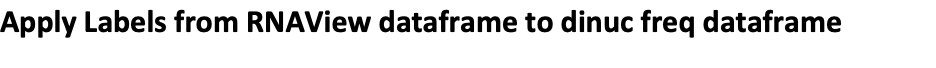

In [ ]:
#read in and format the dataframe which we wrote out earlier

df = pd.read_csv('./dinucleotidefreqDF80.csv')
df['index'] = df['positions']+df['file']
df = df.set_index('index')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df['bond_type'] = '0' 

In [ ]:
#read in the RNAView labels dataframe from earlier 
ef = pd.read_csv('./RNAViewDf80.csv')
ef['file'] = ef['file'].astype(str).str[:4]
ef['file'] = ef['file'].str.upper()
ef['index']=ef['positions']+ef['file']
ef = ef.set_index('index')
ef.drop(ef.columns[ef.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
ef['bondtype'] = ef['bond_type']
ef['bond_type'] = ef['bond_type'].str[1:4]
ef.drop('bondtype', axis = 1,  inplace = True)

Because RNAView uses so many other types of notation no top of the leontis westhof class i fold some of the RNAView classes together into LW classes. Right now i have 17 different classes, but im going to figure out how to get that down to just the 12 LW classes. 

In [ ]:
ef['bond_type'] = ef['bond_type'].str.replace('.','?')
ef['bond_type'] = ef['bond_type'].str.replace('-','W')
ef['bond_type'] = ef['bond_type'].str.replace('+','W')
ef['bond_type'] = ef['bond_type'].str.replace('s','S')
ef['bond_type'] = ef['bond_type'].str.replace('   ','Stack')
ef['bond_type'] = ef['bond_type'].str.replace('  S','Stack')
ef['bond_type'] = ef['bond_type'].str.replace('Syn','Stack')

In [ ]:
#making dictionary to replace bond type strings with integers for one hot encoding 

l = list(set(ef['bond_type']))
l2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
d = dict(zip(l,l2))
d

In [ ]:
ef.replace({'bond_type': d}, inplace = True) #replacing bond type strings with integers so can be one hot encoded


In [ ]:
#takes the leontis-westhof labels from the ef dataframe and applies them to df where applicable 
for index, row in ef.iterrows():        
    df.loc[index,'bond_type'] = row[2]

In [3]:
df = pd.read_csv('./labeleddinucfreq.csv')

In [4]:
df.head()

,index,GA,GG,GC,GU,G-,CC,CU,CG,CA,...,AC,AA,--,-C,-U,-G,-A,positions,file,bond_type
0,1:13D2G,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1:1,3D2G,0
1,1:23D2G,0.0376,0.0187,0.0673,0.0752,0.0001,0.0286,0.0441,0.0407,0.0639,...,0.0931,0.0977,0.0150,0.0003,0.0000,0.0003,0.0002,1:2,3D2G,0
2,1:33D2G,0.0635,0.0308,0.0563,0.0483,0.0000,0.0620,0.0436,0.0253,0.0465,...,0.1293,0.0779,0.0138,0.0002,0.0007,0.0001,0.0010,1:3,3D2G,0
3,1:43D2G,0.0600,0.0362,0.0628,0.0393,0.0006,0.0465,0.0268,0.0431,0.0609,...,0.0650,0.1330,0.0129,0.0015,0.0006,0.0002,0.0006,1:4,3D2G,0
4,1:53D2G,0.0399,0.0422,0.0820,0.0345,0.0002,0.0831,0.0325,0.0153,0.0465,...,0.1509,0.0814,0.0121,0.0018,0.0002,0.0009,0.0009,1:5,3D2G,0


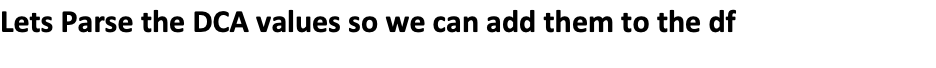

In [ ]:
len_dict = {'RF00001':120,
'RF00008':48,
'RF00017':128,
'RF00023':68,
'RF00027':73,
'RF00102':112,
'RF00166':72,
'RF00174':210,
'RF00207':48,
'RF00209':233,
'RF00210':108,
'RF00374':101,
'RF00480':45,
'RF00500':102,
'RF00634':119,
'RF01073':63,
'RF01381':155,
'RF01704':50,
'RF01727':43,
'RF01739':61,
'RF01857':136,
'RF01998':412,
'RF02012':622,
'RF00005_1':76,
'RF01852':86,
'RF00059':77,
'RF00100':56,
'RF00162':94,
'RF00167':71,
'RF00168':173,
'RF00234':123,
'RF00380':161,
'RF01051':84,
'RF01510':67,
'RF01734':52,
'RF01750':64,
'RF01763':41,
'RF01786':75,
'RF01831_1':89,
'RF01854':106,
'RF00028_1':158,
'RF00169':101,
'RF01767':53,
'RF02682':64,
'RF00163':43,
'RF01054':77,
'RF02695':55,
'RF00233':84,
'RF01807':189,
'RF01415':68,
'RF00379':117,
'RF02683':92,
'RF00921':54,
'RF02679':47,
'RF01982':71,
'RF00606_1':42,
'RF01300':69,
'RF02681':62,
'RF00442_1':85,
'RF00080':99,
'RF01826':48,
'RF03017':71,
'RF00011_1':120,
'RF02540':496,
'RF00029':70,
'RF00010':155,
'RF00164':47,
'RF00458':135,
'RF00050':108,
'RF00504':87,
'RF00044':66,
'RF00061_2':84,
'RF01689':84,
'RF02447':57,
'RF01725':96,
'RF02266':76,
'RF02927':186,
'RF02680':99,
'RF02001_2':258,
'RF02553':80}

In [ ]:
def parse_dca(path):
    '''
    takes path to folder containing dca output files (in format .txt) 
    returns pandas dataframe with columns set as filename, base 1 numbering and base 2 numbering, and dca value
    '''
    
    li = []
    path = path                     
    all_files = glob.glob(path + "/*2")
    
    for filename in all_files:
        print(str(filename)[31:38])
        #note that separation space may need to be adjusted if using RNA that is longer than 1000 bases. check 
        #the column distances in the .txt file 
        df = pd.read_csv(filename, sep = "     ", header = None, names = ['base_1', 'base_2', 'drop_col','dca_val'])
        df.drop('drop_col', axis = 1, inplace = True)
        df['file'] = str(filename)[31:]
        df['base_1'] = df['base_1'].astype(np.int64)
        df['base_2'] = df['base_2'].astype(np.int64)
        df['dca_val'] = df['dca_val'].astype(np.float64)
        
        #do all this again but switch base_1 and base_2 to get the values for the other half of the lxl matrix
        ef = pd.read_csv(filename, sep = "     ", header = None, names = ['base_2', 'base_1', 'drop_col','dca_val'])
        ef.drop('drop_col', axis = 1, inplace = True)
        ef['file'] = str(filename)[31:]
        ef['base_1'] = ef['base_1'].astype(np.int64)
        ef['base_2'] = ef['base_2'].astype(np.int64)
        ef['dca_val'] = ef['dca_val'].astype(np.float64)
        
        #add zeros for 1:1, 2:2, etc
        for i in range(0,len_dict[str(filename)[31:-5]]): 
            df.loc[len(df)+i] = pd.Series({'base_1': i+1 , 'base_2': i+1, 'dca_val': 0.0, 'file': str(filename)[31:]})
        
        li.append(df)
        li.append(ef)
        
    frame = pd.concat(li, axis = 0, ignore_index = True)
    return frame
                     

In [ ]:
df = parse_dca('DCA')

In [ ]:
df.to_csv('../csv/dcadf.csv')

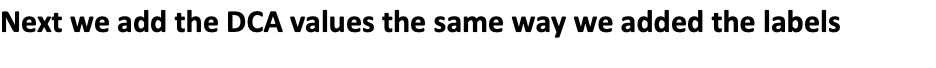

In [ ]:
df = pd.read_csv('../csv/labeleddinucfreq.csv', index_col =0)

In [ ]:
df.drop('16:446HAG', inplace = True) #uncommon residue SAH  101  on chain A [#44] assigned to: a - I dont know what this is but is says this in 6hag.pdb.out


In [ ]:
ef = pd.read_csv('../csv/dcadf.csv', index_col = 0)
ef['file2'] = ef['file'].str.slice(0,-5)
ef.replace({'file2': fileDict}, inplace = True)
ef['positions'] = ef['base_1'].astype(str)+':'+ef['base_2'].astype(str)
ef['index'] = ef['positions']+ef['file2']
ef = ef.set_index('index')

In [ ]:
cf = df.merge(ef, left_index = True, right_index = True)
cf

In [ ]:
cf.drop(['positions_x','positions_y','file_x','file_y','base_1','base_2'], axis = 1, inplace = True)
cf

In [ ]:
cf.to_csv('../csv/labeledfrequenciesanddca_april_26.csv')

 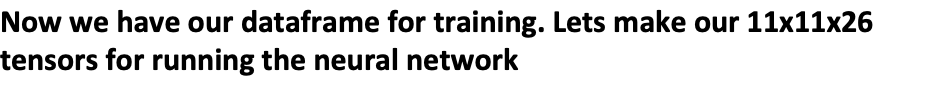

In [3]:


from numpy import savez_compressed
from numpy import save
import math


In [4]:
df = pd.read_csv('./csv/labeledfrequenciesanddca_april_26.csv', index_col=0)

In [5]:
df['bond_type'].value_counts()

0     1618213
8        2958
7         708
17        436
12        314
2         199
1         145
5         101
4          89
9          84
13         76
10         23
14         20
11         18
6          12
15         10
3           6
16          5
Name: bond_type, dtype: int64

In [6]:
df['positions'] = df.index.str.slice(0,-4)
df.rename(columns = {'file2':'file'}, inplace = True)
file = df.pop('file')
df.insert(loc = 28, column = 'file', value = file)
df

,GA,GG,GC,GU,G-,CC,CU,CG,CA,C-,...,AA,--,-C,-U,-G,-A,bond_type,dca_val,positions,file
index,,,,,,,,,,,,,,,,,,,,,
1:13D2G,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.000000,1:1,3D2G
1:23D2G,0.0376,0.0187,0.0673,0.0752,0.0001,0.0286,0.0441,0.0407,0.0639,0.0000,...,0.0977,0.0150,0.0003,0.0000,0.0003,0.0002,0,0.287503,1:2,3D2G
1:33D2G,0.0635,0.0308,0.0563,0.0483,0.0000,0.0620,0.0436,0.0253,0.0465,0.0000,...,0.0779,0.0138,0.0002,0.0007,0.0001,0.0010,0,0.065946,1:3,3D2G
1:43D2G,0.0600,0.0362,0.0628,0.0393,0.0006,0.0465,0.0268,0.0431,0.0609,0.0000,...,0.1330,0.0129,0.0015,0.0006,0.0002,0.0006,0,-0.062766,1:4,3D2G
1:53D2G,0.0399,0.0422,0.0820,0.0345,0.0002,0.0831,0.0325,0.0153,0.0465,0.0000,...,0.0814,0.0121,0.0018,0.0002,0.0009,0.0009,0,0.037044,1:5,3D2G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84:804FRG,0.5236,0.0047,0.0142,0.0425,0.0094,0.0094,0.0047,0.0047,0.0094,0.0000,...,0.1840,0.0425,0.0000,0.0094,0.0000,0.0000,0,-0.017244,84:80,4FRG
84:814FRG,0.0330,0.0047,0.0094,0.0189,0.0000,0.0094,0.0094,0.0000,0.1462,0.0000,...,0.0377,0.0425,0.0000,0.0047,0.0000,0.0000,0,0.071048,84:81,4FRG
84:824FRG,0.0330,0.0047,0.0047,0.0094,0.0000,0.0094,0.0047,0.0000,0.0472,0.0000,...,0.5566,0.0425,0.0000,0.0000,0.0000,0.0000,0,-0.093757,84:82,4FRG


In [7]:
#when i investigated the sequences in the PDB files and the sequences in the MSA's the following files did not match
#therefore for now im dropping them 
drop = ['2H0S','4P5J','4QLN','4RUM','6CB3','6FZ0','1NBS','1FFZ','1U9S','2IL9','3F2Q','4RZD','4Y1O','6CU1']

In [8]:
df = df[df["file"].str.contains('2H0S|4P5J|4QLN|4RUM|6CB3|6FZ0|1NBS|1FFZ|1U9S|2IL9|3F2Q|4RZD|4Y1O|6CU1') == False]

In [9]:
#this is the same test set used by schugg et al. 
test = ['1C2X', '5DI2', '1L9A', '1P6V', '5ZAL', '6OL3', '2MF0', '4GMA', '2KE6', '4C4Q', '2NBX', '1S9S', '1Z2J', '2KRL', '6UES', '2LC8', '2N1Q', '6QN3', '6HAG', '5DDP', '3NDB', '3BWP', '4R0D']

after removing the files that didn't match, the test set was larger than the train set, so i switched them. 

In [10]:
df_test = df.loc[df["file"].isin(test) == False] #i used false here to switch the test and train set

In [11]:
len(df_test)

348774

In [12]:
df_train = df.loc[df["file"].isin(test) ]

In [13]:
len(df_train)

821105

In [ ]:
def make_array(df_slice):
    ef = df_slice
    bondtype = ef.pop('bond_type')
    ef.insert(loc = 27, column = 'bond_type', value = bondtype) #puts the label at the end of the array, need to adjust if addingMI or DCA to 27
    ef.set_index('positions', inplace = True)
    l = int(math.sqrt(len(ef)))
    arr = np.ones([l, l, 27]) #change to 27 if including mi val or dca val
    for i in range(l):
        for j in range(l): 
            
            arr[i,j,:] = ef.loc[str(i+1)+':'+str(j+1)][0:27] #change to 27 if including MI or DCA val 
    return arr



def make_frames(df):
    frames = []
    labels = []
    for file in set(df['file']):
        print(file)
        arr = make_array(df[df['file'] == file])
        for x in range(len(arr)-11): #0-29
            for y in range(len(arr)-11):
                array_11x11x25 = arr[x:x+11,y:y+11,:-1] #drop the label, first array is arr[0:11], slice is not inclusive of 11
                label = arr[x+5, y+5, -1] #make the label, in this case 0+5 = 5 which is index 6 
                frames.append(array_11x11x25) 
                labels.append(label)
    return frames, labels

In [ ]:
frames_train, labels_train = make_frames(df_train)

X =  np.array(frames_train, dtype = np.float32)

savez_compressed('dca_frames_train.npz', X)

y = np.array(labels_train)

save('dca_labels_train.npy', y)

Now that we have our tensors made we can run a neural network. I will do this in a seperate notebook since this one is getting too long. 